# Project COGS 189: EEG-Based Attention State Classification Using Machine Learning


Mohsin Khawaja A17643078

Samer Ahmed A17001877

Xavier Lopez A17068366

#### Recommended Environment Setup
```  conda create --name "cogs189" python=3.9   ```

``` conda activate cogs189 ```

#### Now run the following cell to install the requirements.txt

In [1]:
import os
if not os.path.exists("requirements_installed.txt"):
    import sys
    !{sys.executable} -m pip install -r requirements.txt --quiet
    with open("requirements_installed.txt", "w") as f:
        f.write("installed")

#### Test to see if the installation worked by importing the needed libraries

In [2]:
import zipfile
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import welch, butter, lfilter
import mne 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

#### Proceeding to handling the data

1. First, download the zip file locally and place it into the same folder as project. (Next to this notebook file.)

* Due to the large file size even when zipped, Git/Github is not viable solution for holding/transfering.

In [3]:
zipped_name = "data_preprocessed_python.zip"
unzipped_folder = "data_preprocessed_python"

if not os.path.exists(unzipped_folder):
    print("Extracting files...")
    with zipfile.ZipFile(zipped_name, 'r') as zip_ref:
        zip_ref.extractall(os.getcwd())
    print(f"Extracted files into: {os.getcwd()}")
else:
    print("Files already extracted.")

files = [f for f in os.listdir(unzipped_folder) if f.endswith(".dat")]
print(f"Found {len(files)} EEG data files in {unzipped_folder}.")

Files already extracted.
Found 32 EEG data files in data_preprocessed_python.


In [4]:
data_dir = 'data_preprocessed_python'
print("Files in the directory:", os.listdir(data_dir))

Files in the directory: ['s28.dat', 's14.dat', 's01.dat', 's15.dat', 's29.dat', 's03.dat', 's17.dat', 's16.dat', 's02.dat', 's06.dat', 's12.dat', 's13.dat', 's07.dat', 's11.dat', 's05.dat', 's04.dat', 's10.dat', 's09.dat', 's21.dat', 's20.dat', 's08.dat', 's22.dat', 's23.dat', 's27.dat', 's32.dat', 's26.dat', 's30.dat', 's24.dat', 's18.dat', 's19.dat', 's25.dat', 's31.dat']


In [5]:
data_dir = 'data_preprocessed_python'
eeg_files = sorted([f for f in os.listdir(data_dir) if f.endswith('.dat')])

header_bytes = 1480  
expected_shape = (40, 32, 20160)
expected_size = np.prod(expected_shape)

for file in eeg_files:
    file_path = os.path.join(data_dir, file)
    try:
        data = np.fromfile(file_path, dtype=np.float32, offset=header_bytes)
    except Exception as e:
        print(f"Error processing {file}: {e}")
        continue

    if data.size != expected_size:
        print(f"{file}: Unexpected number of elements after header: {data.size} (expected {expected_size}).")
    else:
        data = data.reshape(expected_shape)
        print(f"{file}: shape = {data.shape}")
        total_samples = expected_shape[0] * expected_shape[2]  
        print(f"    Total samples (trials x samples): {total_samples}")



s01.dat: shape = (40, 32, 20160)
    Total samples (trials x samples): 806400
s02.dat: shape = (40, 32, 20160)
    Total samples (trials x samples): 806400
s03.dat: shape = (40, 32, 20160)
    Total samples (trials x samples): 806400
s04.dat: shape = (40, 32, 20160)
    Total samples (trials x samples): 806400
s05.dat: shape = (40, 32, 20160)
    Total samples (trials x samples): 806400
s06.dat: shape = (40, 32, 20160)
    Total samples (trials x samples): 806400
s07.dat: shape = (40, 32, 20160)
    Total samples (trials x samples): 806400
s08.dat: shape = (40, 32, 20160)
    Total samples (trials x samples): 806400
s09.dat: shape = (40, 32, 20160)
    Total samples (trials x samples): 806400
s10.dat: shape = (40, 32, 20160)
    Total samples (trials x samples): 806400
s11.dat: shape = (40, 32, 20160)
    Total samples (trials x samples): 806400
s12.dat: shape = (40, 32, 20160)
    Total samples (trials x samples): 806400
s13.dat: shape = (40, 32, 20160)
    Total samples (trials x sam

### Load & Structure EEG Data

In [6]:
all_eeg_data = []
all_labels = []

for file in files:
    file_path = os.path.join(unzipped_folder, file)
    with open(file_path, 'rb') as f:
        participant_data = pickle.load(f, encoding='latin1')
        
        eeg_data = participant_data['data'][:, :32, :]
        labels = participant_data['labels']
        
        all_eeg_data.append(eeg_data)
        all_labels.append(labels)

all_eeg_data = np.array(all_eeg_data)
all_labels = np.array(all_labels)

print("Final EEG Dataset Shape:", all_eeg_data.shape)
print("Final Labels Shape:", all_labels.shape)

Final EEG Dataset Shape: (32, 40, 32, 8064)
Final Labels Shape: (32, 40, 4)


### Visualize a Sample EEG

/Users/samerahmed/Library/Python/3.9/lib/python/site-packages/matplotlib/cbook.py:1398: RuntimeWarning: invalid value encountered in cast
  return np.asarray(x, float)


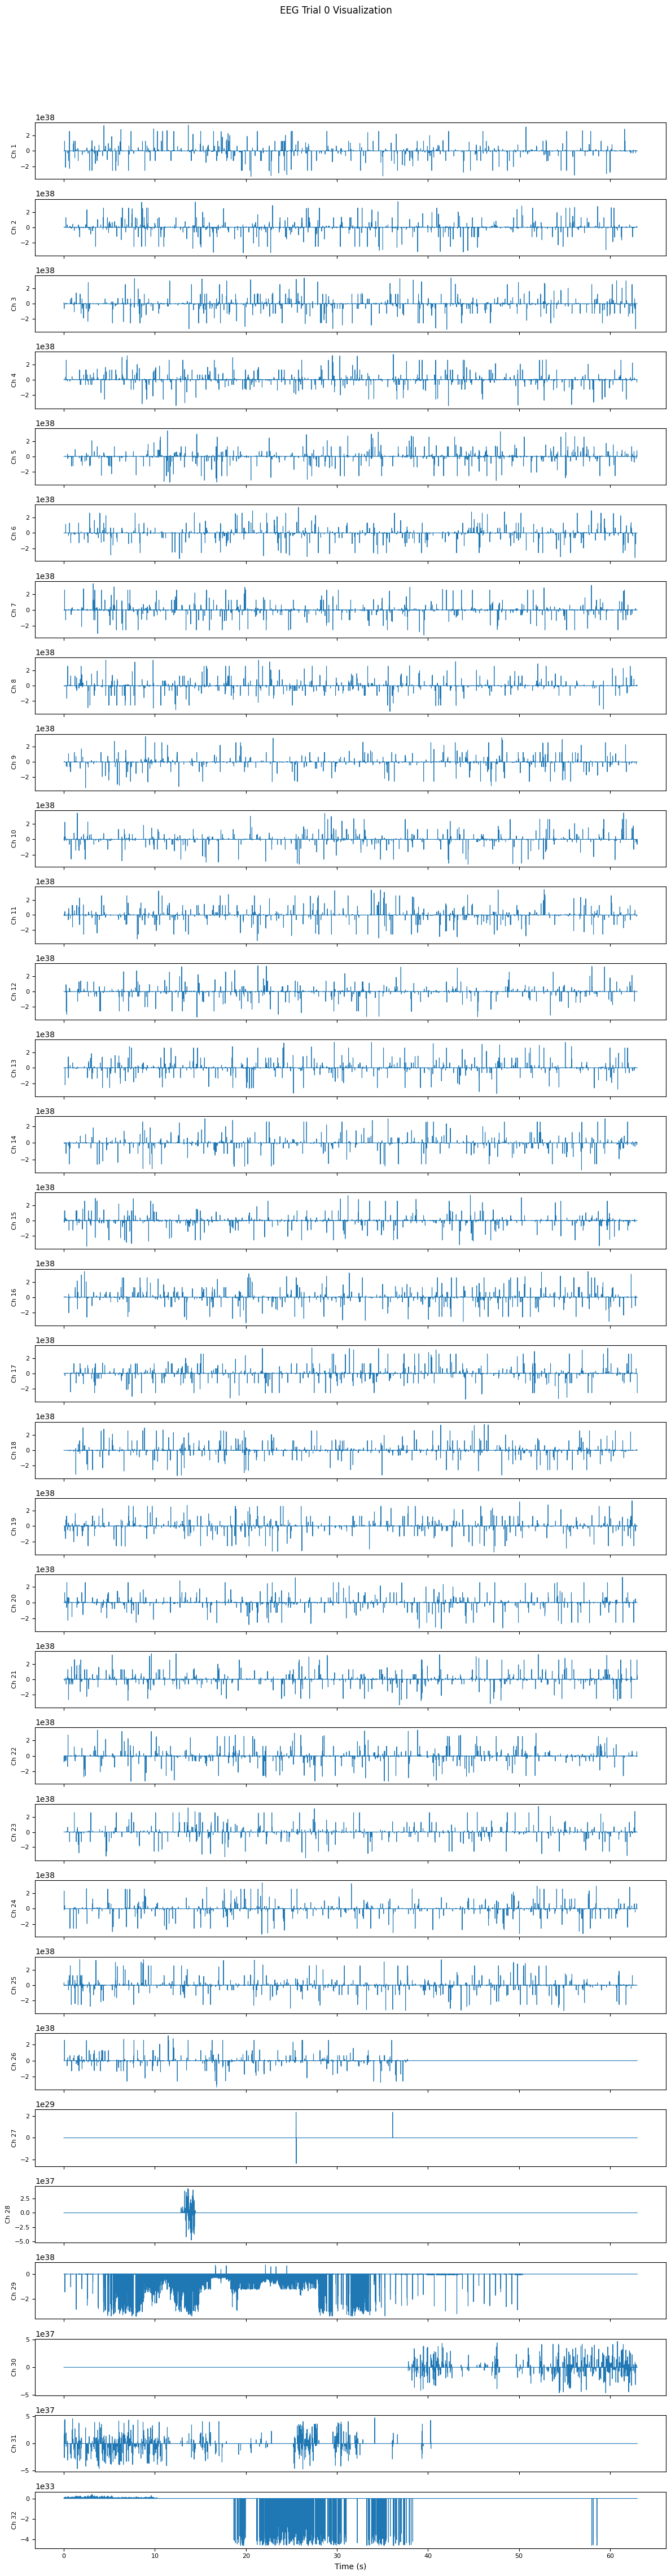

In [7]:
trial_index = 0
trial_data = data[trial_index]  
n_channels, n_samples = trial_data.shape

fs = 320  
time = np.arange(n_samples) / fs 

fig, axs = plt.subplots(n_channels, 1, figsize=(12, n_channels*1.5), sharex=True)
for ch in range(n_channels):
    axs[ch].plot(time, trial_data[ch], lw=0.8)
    axs[ch].set_ylabel(f"Ch {ch+1}", fontsize=8)
    axs[ch].tick_params(labelsize=8)
axs[-1].set_xlabel("Time (s)", fontsize=10)
plt.suptitle("EEG Trial 0 Visualization", fontsize=12)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


### Visualize a Sample EEG Signal

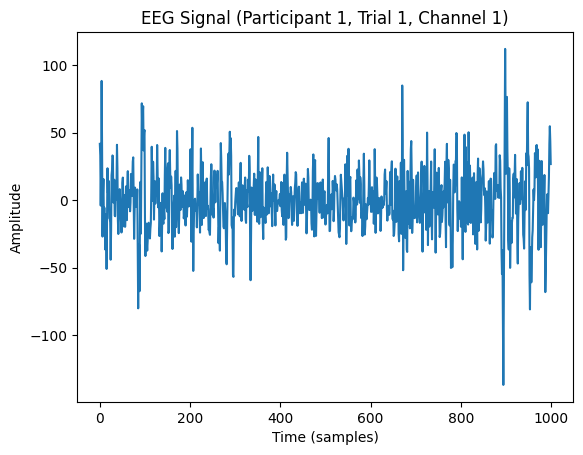

In [8]:
participant = 0
trial = 0
channel = 0

plt.plot(all_eeg_data[participant, trial, channel, :1000])  # First 1000 timepoints
plt.title(f"EEG Signal (Participant {participant+1}, Trial {trial+1}, Channel {channel+1})")
plt.xlabel("Time (samples)")
plt.ylabel("Amplitude")
plt.show()

### Apply EEG Preprocessing

#### Check the frequency spectrum

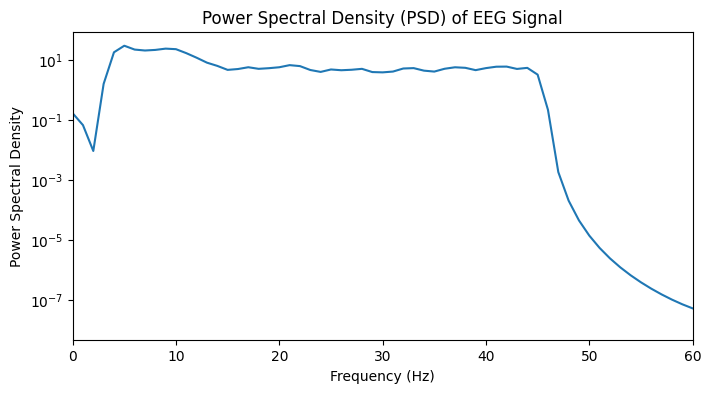

In [9]:
eeg_signal = all_eeg_data[0, 0, 0, :]

fs = 128
freqs, psd = welch(eeg_signal, fs, nperseg=fs)

plt.figure(figsize=(8, 4))
plt.semilogy(freqs, psd)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power Spectral Density")
plt.title("Power Spectral Density (PSD) of EEG Signal")
plt.xlim(0, 60)
plt.show()

The Power Spectral Density (PSD) plot confirms that the EEG signal is already bandpass filtered between 4 Hz and 45 Hz. There is no significant power in frequencies below 4 Hz or above 45 Hz, meaning the preprocessed dataset has already removed unwanted frequency components.

### Segment EEG into Time Windows

Segmenting EEG data into time windows is important because EEG signals are highly dynamic and non-stationary - their properties can change rapidly over time. By dividing the continuous EEG signal into shorter epochs, we can assume that each segment is approximately stationary, which makes it easier to apply signal processing techniques

In [10]:
def segment_data_per_trial(data, window_size=256, step_size=128):
    segmented_trials = []

    for participant in range(data.shape[0]):
        participant_segments = []
        for trial in range(data.shape[1]):
            segments = []
            trial_data = data[participant, trial]
            for start in range(0, trial_data.shape[-1] - window_size, step_size):
                segments.append(trial_data[:, start:start + window_size])
            participant_segments.append(np.array(segments))
        segmented_trials.append(np.array(participant_segments))

    return np.array(segmented_trials)

segmented_eeg = segment_data_per_trial(all_eeg_data)

print("Corrected Segmented EEG Shape:", segmented_eeg.shape)
# Expected: (32, 40, 61, 32, 256)

Corrected Segmented EEG Shape: (32, 40, 61, 32, 256)


### Extract Frequency Features

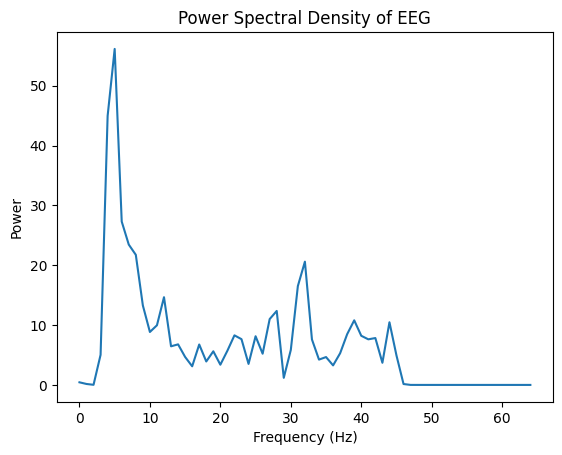

In [11]:
def compute_psd(eeg_signal, fs=128):
    freqs, psd = welch(eeg_signal, fs, nperseg=fs)  # Compute Power Spectral Density
    return freqs, psd

sample_eeg_segment = segmented_eeg[0, 0, 0, 0, :]  # (participant, trial, segment, channel, time)

freqs, psd = compute_psd(sample_eeg_segment)

plt.plot(freqs, psd)
plt.title("Power Spectral Density of EEG")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power")
plt.show()

### Frequency Band Power Extraction Processing

In [12]:
def extract_band_power(psd, freqs, bands={'theta': (4, 8), 'alpha': (8, 13), 'beta': (13, 30), 'gamma': (30, 45)}):
    band_powers = {}
    for band, (low, high) in bands.items():
        idx = np.where((freqs >= low) & (freqs <= high))
        band_powers[band] = np.mean(psd[idx])
    return band_powers

features_list = []

for participant in range(segmented_eeg.shape[0]):
    for trial in range(segmented_eeg.shape[1]):
        for segment in range(segmented_eeg.shape[2]):
            segment_features = {}
            
            for channel in range(segmented_eeg.shape[3]):
                eeg_signal = segmented_eeg[participant, trial, segment, channel, :]
                
                freqs, psd = compute_psd(eeg_signal)

                band_powers = extract_band_power(psd, freqs)

                for band, power in band_powers.items():
                    segment_features[f"Ch{channel+1}_{band}"] = power
            
            segment_features["participant"] = participant
            segment_features["trial"] = trial
            segment_features["segment"] = segment
            
            features_list.append(segment_features)

df_features = pd.DataFrame(features_list)

print(df_features.head())

   Ch1_theta  Ch1_alpha  Ch1_beta  Ch1_gamma  Ch2_theta  Ch2_alpha  Ch2_beta  \
0  34.719148  12.491228  6.088634   8.127150  20.567578  10.421573  7.038770   
1  14.837643  16.194875  7.532733   5.744115  11.713629  15.195857  8.080758   
2   6.482831   7.567323  5.865260   4.017712   4.587964   7.540463  6.146646   
3   5.721155   7.290100  5.816388   3.746272   5.755174   7.452777  5.528686   
4   7.524442   7.817093  5.681470   8.981711   7.578799   7.205118  5.133516   

   Ch2_gamma  Ch3_theta  Ch3_alpha  ...  Ch31_alpha  Ch31_beta  Ch31_gamma  \
0   8.819701  53.883115  11.240943  ...   17.421523   8.610681   10.923950   
1   5.997644  24.407153  13.682537  ...   20.455081   9.941843    7.864048   
2   3.905201  12.155751   6.274768  ...   11.212588   7.442963    5.178248   
3   3.533932   3.456029   4.323512  ...    9.900873   5.966563    4.160738   
4   8.492576   5.395734   3.455396  ...    8.638751   6.190805    9.128381   

   Ch32_theta  Ch32_alpha  Ch32_beta  Ch32_gamma  

#### Export to CSV

In [13]:
df_features.to_csv("eeg_extracted_features.csv", index=False)

print("Feature extraction complete. Data saved as eeg_extracted_features.csv")

Feature extraction complete. Data saved as eeg_extracted_features.csv


 SVM Model (Baseline)

In [14]:
df_features = pd.read_csv("eeg_extracted_features.csv")
print("DataFrame columns:", df_features.columns.tolist())

df_features['dummy_label'] = np.random.randint(0, 2, size=len(df_features))

X = df_features.drop(['participant', 'trial', 'segment', 'dummy_label'], axis=1)
y = df_features['dummy_label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

svm_model = SVC(kernel='rbf', C=1, gamma='scale')
svm_model.fit(X_train_scaled, y_train)

y_pred = svm_model.predict(X_test_scaled)
print("SVM Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


DataFrame columns: ['Ch1_theta', 'Ch1_alpha', 'Ch1_beta', 'Ch1_gamma', 'Ch2_theta', 'Ch2_alpha', 'Ch2_beta', 'Ch2_gamma', 'Ch3_theta', 'Ch3_alpha', 'Ch3_beta', 'Ch3_gamma', 'Ch4_theta', 'Ch4_alpha', 'Ch4_beta', 'Ch4_gamma', 'Ch5_theta', 'Ch5_alpha', 'Ch5_beta', 'Ch5_gamma', 'Ch6_theta', 'Ch6_alpha', 'Ch6_beta', 'Ch6_gamma', 'Ch7_theta', 'Ch7_alpha', 'Ch7_beta', 'Ch7_gamma', 'Ch8_theta', 'Ch8_alpha', 'Ch8_beta', 'Ch8_gamma', 'Ch9_theta', 'Ch9_alpha', 'Ch9_beta', 'Ch9_gamma', 'Ch10_theta', 'Ch10_alpha', 'Ch10_beta', 'Ch10_gamma', 'Ch11_theta', 'Ch11_alpha', 'Ch11_beta', 'Ch11_gamma', 'Ch12_theta', 'Ch12_alpha', 'Ch12_beta', 'Ch12_gamma', 'Ch13_theta', 'Ch13_alpha', 'Ch13_beta', 'Ch13_gamma', 'Ch14_theta', 'Ch14_alpha', 'Ch14_beta', 'Ch14_gamma', 'Ch15_theta', 'Ch15_alpha', 'Ch15_beta', 'Ch15_gamma', 'Ch16_theta', 'Ch16_alpha', 'Ch16_beta', 'Ch16_gamma', 'Ch17_theta', 'Ch17_alpha', 'Ch17_beta', 'Ch17_gamma', 'Ch18_theta', 'Ch18_alpha', 'Ch18_beta', 'Ch18_gamma', 'Ch19_theta', 'Ch19_alpha'

CNN Model (1D Convolution for Time-Series Data)

In [15]:
import sys
print(sys.executable)

import numpy as np
import tensorflow as tf
print(tf.__version__)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

num_classes = 3  

X_time = np.random.rand(100, 50, 10)
y_time = np.random.randint(0, 3, size=(100,))

y_onehot = to_categorical(y_time, num_classes)

model = Sequential([
    Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(X_time.shape[1], X_time.shape[2])),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),
    Conv1D(filters=64, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

history = model.fit(X_time, y_onehot, epochs=20, batch_size=32, validation_split=0.2)


/Library/Developer/CommandLineTools/usr/bin/python3


/Users/samerahmed/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


2.19.0


/Users/samerahmed/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 48, 32)         │           992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 24, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 22, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 11, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 704)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        45,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,515 (205.14 KB)

 Trainable params: 52,515 (205.14 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.3750 - loss: 1.1181 - val_accuracy: 0.2000 - val_loss: 1.1787
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.4453 - loss: 1.1051 - val_accuracy: 0.2000 - val_loss: 1.1834
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.4086 - loss: 1.0775 - val_accuracy: 0.3000 - val_loss: 1.1136
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.4344 - loss: 1.0608 - val_accuracy: 0.4500 - val_loss: 1.0887
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.3875 - loss: 1.0811 - val_accuracy: 0.2000 - val_loss: 1.1111
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.4703 - loss: 1.0661 - val_accuracy: 0.1500 - val_loss: 1.1363
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.4234 - loss: 1.0372 - val_accuracy: 0.2000 - val_loss: 1.1806
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.4094 - loss: 1.0631 - val_accuracy: 0.2000 - val_loss: 1.1790


LSTM Model (Capturing Temporal Dynamics)

In [16]:
from tensorflow.keras.layers import LSTM

model = Sequential([
    LSTM(64, input_shape=(X_time.shape[1], X_time.shape[2]), return_sequences=True),
    Dropout(0.2),
    LSTM(32),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

history = model.fit(X_time, y_onehot, epochs=20, batch_size=32, validation_split=0.2)


/Users/samerahmed/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50, 64)         │        19,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 50, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,923 (132.51 KB)

 Trainable params: 33,923 (132.51 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 0.4313 - loss: 1.0763 - val_accuracy: 0.2000 - val_loss: 1.1307
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.3273 - loss: 1.1087 - val_accuracy: 0.2000 - val_loss: 1.1286
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.3633 - loss: 1.0884 - val_accuracy: 0.2000 - val_loss: 1.1536
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.3414 - loss: 1.0848 - val_accuracy: 0.2000 - val_loss: 1.1647
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.3750 - loss: 1.0830 - val_accuracy: 0.2000 - val_loss: 1.1546
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.3836 - loss: 1.0888 - val_accuracy: 0.2000 - val_loss: 1.1348
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4180 - loss: 1.0740 - val_accuracy: 0.2000 - val_loss: 1.1186
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.3703 - loss: 1.0828 - val_accuracy: 0.2500 - val_loss: 1.1102

**SVM & CNN:** The SVM provides a robust baseline using engineered frequency features, while the CNN extracts local spatial-temporal patterns from raw EEG signals.  

**LSTM:** Captures long-term temporal dependencies in brain activity, completing our multi-model approach for attention state classification.


/var/folders/cj/tnt9nc8x1w360tt993qr3z000000gn/T/ipykernel_99097/1672869453.py:24: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  power = np.trapz(psd[idx_band], freqs[idx_band])


Dominant band counts: Counter({'beta': 212143, 'gamma': 87734, 'theta': 56, 'alpha': 43, 'delta': 24})


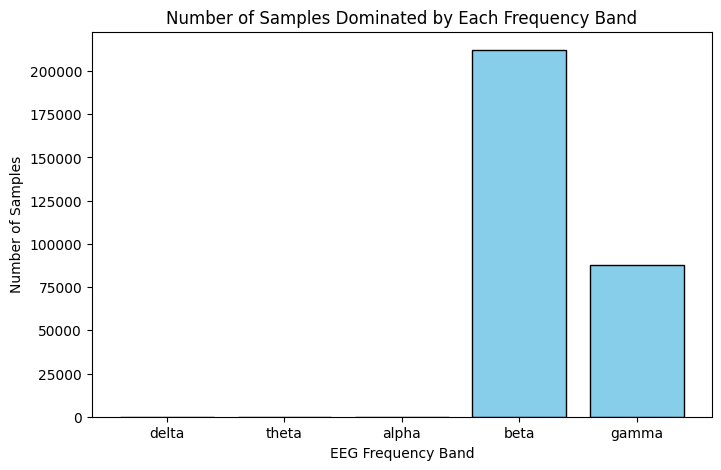

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch
import collections

n_samples = 300000
timesteps = 256  
n_channels = 1   
X_time = np.random.rand(n_samples, timesteps, n_channels)

fs = 128

bands = {
    'delta': (0.5, 4),
    'theta': (4, 8),
    'alpha': (8, 12),
    'beta': (12, 30),
    'gamma': (30, 45)
}

def compute_band_power(signal, fs, band):
    freqs, psd = welch(signal, fs=fs, nperseg=256)
    idx_band = np.logical_and(freqs >= band[0], freqs <= band[1])
    power = np.trapz(psd[idx_band], freqs[idx_band])
    return power

dominant_bands = []
for i in range(n_samples):
    signal = X_time[i, :, 0]
    band_powers = {band: compute_band_power(signal, fs, rng) for band, rng in bands.items()}
    dom_band = max(band_powers, key=band_powers.get)
    dominant_bands.append(dom_band)

band_counts = collections.Counter(dominant_bands)
print("Dominant band counts:", band_counts)

bands_order = ['delta', 'theta', 'alpha', 'beta', 'gamma']
counts = [band_counts.get(b, 0) for b in bands_order]

plt.figure(figsize=(8, 5))
plt.bar(bands_order, counts, color='skyblue', edgecolor='black')
plt.xlabel('EEG Frequency Band')
plt.ylabel('Number of Samples')
plt.title('Number of Samples Dominated by Each Frequency Band')
plt.show()


This above cell code process helps in understanding which frequency bands are most prevalent in the simulated EEG data.

In [18]:
import numpy as np
import random
from scipy.signal import welch

bands = {
    'delta': (0.5, 4),
    'theta': (4, 8),
    'alpha': (8, 12),
    'beta': (12, 30),
    'gamma': (30, 45)
}

def compute_band_power(signal, fs, band_range):
    freqs, psd = welch(signal, fs=fs, nperseg=256)
    band_idx = np.logical_and(freqs >= band_range[0], freqs <= band_range[1])
    power = np.trapz(psd[band_idx], freqs[band_idx])
    return power

target_band = 'theta'
theta_indices = [i for i, band in enumerate(dominant_bands) if band == target_band]

if theta_indices:
    theta_powers = [compute_band_power(X_time[i, :, 0], fs, bands[target_band]) for i in theta_indices]
    
    total_power = sum(theta_powers)
    if total_power > 0:
        theta_probs = [power / total_power for power in theta_powers]
    else:
        theta_probs = None
    
    random_index = np.random.choice(theta_indices, p=theta_probs)
    print(f"Random sample index {random_index} (weighted by theta power) is dominated by '{target_band}'.")
    
    print(f"Theta power for sample {random_index}: {compute_band_power(X_time[random_index, :, 0], fs, bands[target_band])}")
else:
    print(f"No sample found with dominant band '{target_band}'.")


Random sample index 215719 (weighted by theta power) is dominated by 'theta'.
Theta power for sample 215719: 0.018142182114520657


/var/folders/cj/tnt9nc8x1w360tt993qr3z000000gn/T/ipykernel_99097/2260637334.py:16: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  power = np.trapz(psd[band_idx], freqs[band_idx])


This process in the above cell can be useful for analyzing or showcasing samples that strongly exhibit theta activity in your EEG dataset.

In [19]:
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt

def interactive_eeg_demo(participant, trial, segment, channel):
    sample_signal = segmented_eeg[participant, trial, segment, channel, :]
    time = np.arange(len(sample_signal)) / fs 
    
    plt.figure(figsize=(10, 4))
    plt.plot(time, sample_signal)
    plt.title(f"EEG Signal\nParticipant {participant+1}, Trial {trial+1}, Segment {segment+1}, Channel {channel+1}")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.show()
    
    freqs, psd = compute_psd(sample_signal, fs=fs)
    
    band_powers = extract_band_power(psd, freqs)
    
    print("Computed Band Powers:")
    for band, power in band_powers.items():
        print(f"  {band.capitalize()}: {power:.2f}")
    
    dominant_band = max(band_powers, key=band_powers.get)
    print(f"\nDominant Frequency Band: {dominant_band.capitalize()}")

participant_slider = widgets.IntSlider(value=0, min=0, max=segmented_eeg.shape[0]-1, description='Participant:')
trial_slider = widgets.IntSlider(value=0, min=0, max=segmented_eeg.shape[1]-1, description='Trial:')
segment_slider = widgets.IntSlider(value=0, min=0, max=segmented_eeg.shape[2]-1, description='Segment:')
channel_slider = widgets.IntSlider(value=0, min=0, max=segmented_eeg.shape[3]-1, description='Channel:')

widgets.interactive(interactive_eeg_demo, 
                    participant=participant_slider, 
                    trial=trial_slider, 
                    segment=segment_slider, 
                    channel=channel_slider)


interactive(children=(IntSlider(value=0, description='Participant:', max=31), IntSlider(value=0, description='…

The above output features as a basic interface to visualize and see what each signal is strongly categorized as. 

**Real-Time Interaction Code:** Interactively displays a selected EEG segment, computes its frequency band powers using Welch's method, and identifies the dominant frequency band.  

**Limitations:** Operates on preprocessed, static data (not live streams), supports one channel at a time, and depends on accurate pre-segmentation and sampling rate.
